## HISTOGRAM METHOD - 2D ISING MODEL

In [1]:
#Libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from scipy.optimize import fsolve
import scipy as sc

#Color map
import matplotlib as mpl
#style of plots
mpl.style.use('tableau-colorblind10')

In [3]:
#listing the files with the simulations
folder = 'data_ISING_2D'
files = os.listdir(folder)

#hyperparameter
N_cut = 10_000
thinning = 10

#Bins of energy 
E_bins = np.linspace(-1.75, -0.74, 51)
bin_centers = (E_bins[1:]+E_bins[:-1])/2

#list to store the data
betas = []
E_values = []
E_mean = []
E_std = []

FileNotFoundError: [Errno 2] No such file or directory: 'data_ISING_2D_1'

In [20]:
for file in files: 
    #extracting parameters from file name
    pattern_beta = r"beta(.*?)time"
    beta= float(re.findall(pattern_beta, file)[0])

    pattern_N = r"N(.*?)_L"
    N = int(re.findall(pattern_N, file)[0])

    pattern_timesteps = r"time(.*?).txt"
    timesteps = int(re.findall(pattern_timesteps, file)[0])

    L = int(np.sqrt(N))

    #extracting data from file
    data = np.loadtxt(folder + '/' + file)
    time = data[:,0]
    energy = data[:,1]

    #thinning and cutting the data
    time = time[N_cut::thinning]
    energy = energy[N_cut::thinning]

    #energy per spin
    energy = energy/N
    
    #storing the data
    betas.append(beta)
    E_values.append(energy)
    E_mean.append(np.mean(energy))
    E_std.append(np.std(energy))

    print('Beta:', beta)

Beta: 0.437
Beta: 0.411
Beta: 0.446
Beta: 0.42
Beta: 0.429


### SINGLE HISTOGRAM METHOD

In [24]:
def single_histogram_method(beta_in, E_in, N, beta_out):
    num = np.sum(E_in*np.exp((beta_in-beta_out)*E_in*N))
    den = np.sum(np.exp((beta_in-beta_out)*E_in*N))
    return num/den

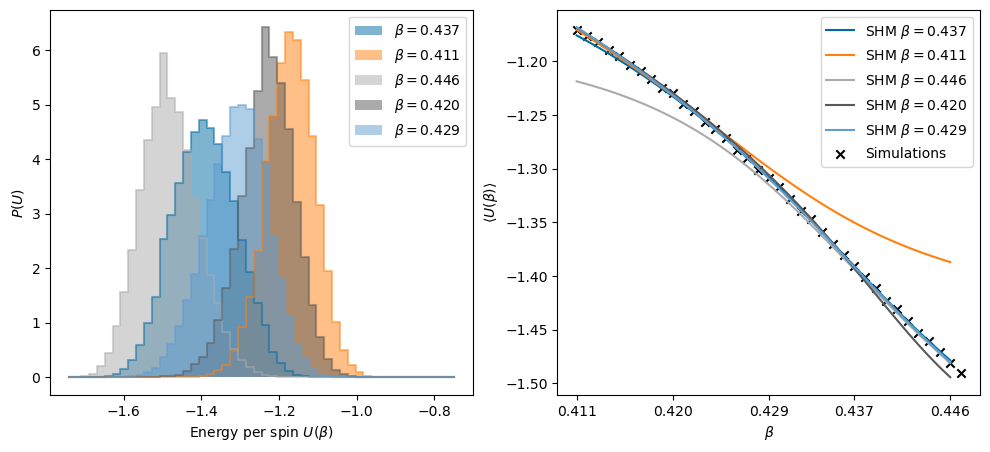

In [25]:
#list of betas or extrapolation
beta_list = np.linspace(min(betas), max(betas), 100)

#plotting the results
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

#Histogramming the energy distributions
for E, beta in zip(E_values, betas):
    counts, _ = np.histogram(E, bins=E_bins, density=True)
    ax[0].fill_between(bin_centers, counts, step  = 'mid', alpha=0.5, label=r'$\beta ={:0.3f} $'.format(beta))
    ax[0].step(bin_centers, counts, where  = 'mid', alpha=0.5)
    
ax[0].legend()
ax[0].set_xlabel(r'Energy per spin $U(\beta)$')
ax[0].set_ylabel(r'$P(U)$')


#Single Histogram Method anc comparison with simulations

folder_sim = 'data_ISING_2D_complete'
files_sim = os.listdir(folder_sim)
sim = []
beta_complete = []
for file in files_sim:
    #extracting parameters from file name
    pattern_beta = r"beta(.*?)time"
    beta= float(re.findall(pattern_beta, file)[0])
    pattern_N = r"N(.*?)_L"
    N = int(re.findall(pattern_N, file)[0])
    
    data = np.loadtxt(folder_sim + '/' + file)
    energy = data[:,1]
    energy = energy[N_cut::thinning]
    energy = energy/N
    sim.append(np.mean(energy))
    beta_complete.append(beta)



for i in range(len(betas)):
    ax[1].plot(np.array(beta_list), np.array([single_histogram_method(betas[i], E_values[i], N, beta) for beta in beta_list]), label=r'SHM $\beta ={:0.3f} $'.format(betas[i]))

ax[1].scatter(np.array(beta_complete), sim, color='black', label = 'Simulations', marker='x')
ax[1].set_xlabel(r'$\beta$')
ax[1].set_ylabel(r'$ \langle U(\beta) \rangle $')
ax[1].legend()
ax[1].set_xticks(sorted(np.array(betas)))

plt.savefig('plots/SHM.png')

### MULTIPLE HISTOGRAM METHOD

#### Reading simulations

In [79]:
#listing the files with the simulations
folder = 'data_ISING_2D'
files = os.listdir(folder)

#hyperparameter
N_cut = 10_000
thinning = 200

#Bins of energy 
E_bins = np.linspace(-1.75, -0.74, 51)
bin_centers = (E_bins[1:]+E_bins[:-1])/2

#Lists to store data
E_samples = []
beta_samples = []

In [80]:
for file in files:
    #extracting parameters from file name
    pattern_beta = r"beta(.*?)time"
    beta= float(re.findall(pattern_beta, file)[0])

    pattern_N = r"N(.*?)_L"
    N = int(re.findall(pattern_N, file)[0])

    pattern_timesteps = r"time(.*?).txt"
    timesteps = int(re.findall(pattern_timesteps, file)[0])

    L = int(np.sqrt(N))

    #extracting data from file
    data = np.loadtxt(folder + '/' + file)
    time = data[:,0]
    energy = data[:,1]

    #thinning and cutting the data
    time = time[N_cut::thinning]
    energy = energy[N_cut::thinning]

    #energy per spin

    E_samples.append(energy)
    beta_samples.append(beta)

E_samples = np.array(E_samples)
beta_samples = np.array(beta_samples)

params = [beta_samples, E_samples]

#### Solving self-consistent equation for Zs

In [102]:
#Self-consistent equations for Zk
def equations_for_Zs(Zs, params):
    #unpacking
    betas = params[0]
    Es = params[1]

    #rescaling
    A = np.sqrt(np.max(Zs)*np.min(Zs))
    Zs = Zs/A

    #writing the equations
    eq = np.zeros(len(Zs))

    for k in range(len(Zs)):

        sum_i = 0

        for i in range(len(Es)):

            sum_j = np.zeros(len(Es[0]))

            for j in range(len(Zs)):

                sum_j = sum_j + (1./Zs[j]*np.exp((betas[k]-betas[j])*Es[i]))

            sum_i = sum_i + np.sum(1./sum_j)

        eq[k] = np.sum(sum_i)

    return eq


def convergence(Zs, Zs_old, toll):
    if np.sum(((Zs-Zs_old)/Zs)**2)<toll:
        return True
    else:
        return False


def iterative_method(equations, initial_guess, params, a = 0.3, toll = 1e-7, max_iter = 1000):

    Zs_story = []

    #initial guess
    Zs = initial_guess
    Zs_story.append(Zs)

    #iteration
    for i in range(max_iter):

        #computing the equations
        eq = equations(Zs, params)

        #checking the convergence
        if convergence(eq, Zs, toll):
            Zs = Zs*(1-a) + eq*a  #soft injection for stability
            Zs_story.append(Zs)
            break

        #updating the guess
        Zs = Zs*(1-a) + eq*a
        Zs_story.append(Zs)

        if i == max_iter-1:
            print('Max number of iterations reached')

    return Zs, np.array(Zs_story)

In [103]:
#iterativ solution
initial_guess = np.ones(len(beta_samples))*10
Zs, Zs_story = iterative_method(equations_for_Zs, initial_guess, params)


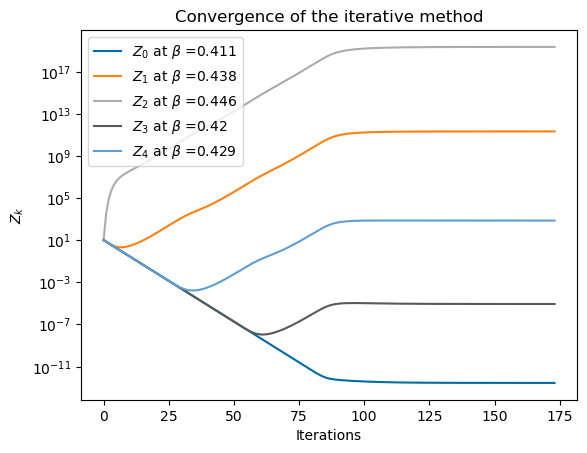

In [104]:
for i in range(len(Zs)):
    plt.plot(np.arange(Zs_story.shape[0]), Zs_story[:, i], label= r'$Z_{}$ at $\beta$ ={}'.format(i, beta_samples[i]))
plt.yscale('log')
plt.legend()
plt.title('Convergence of the iterative method')
plt.xlabel('Iterations')
plt.ylabel(r'$Z_k$')
plt.savefig('plots/convergence_Z_k.png')

#### Computing Z(beta)

In [106]:
def Z(beta_list, Zs, params):
    
    betas = params[0]
    Es = params[1]
    Z_b = []

    for beta in beta_list:

        sum_i = 0

        for i in range(len(Es)):

            sum_j = np.zeros(len(Es[0]))

            for j in range(len(Zs)):

                sum_j = sum_j + (1./Zs[j]*np.exp((beta-betas[j])*Es[i]))
        
            sum_i = sum_i + np.sum(1./sum_j)
        
        Z_b.append(sum_i)

    return np.array(Z_b)

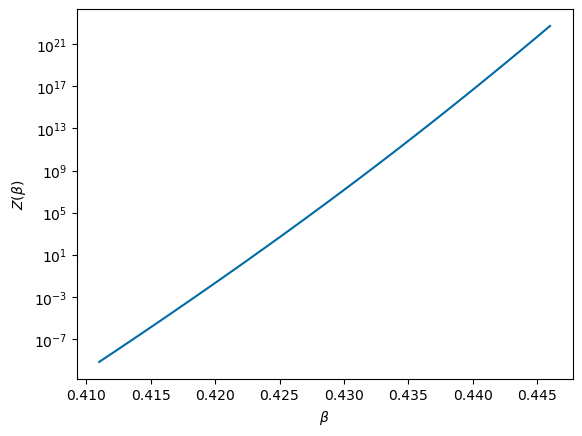

In [107]:
beta_list = np.linspace(min(beta_samples), max(beta_samples), 100)
Z_b = Z(beta_list, Zs, params)

plt.plot(beta_list, Z_b)
plt.yscale('log')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$Z(\beta)$')
plt.savefig('plots/Z_beta.png')

#### Computing Observables

In [109]:
def compute_obs(obs_samples, beta_list, Zs, params):
    
    betas = params[0]
    Es = params[1]
    obs = []

    Z_b = Z(beta_list, Zs, params)

    for beta in beta_list:

        sum_i = 0

        for i in range(len(Es)):

            sum_j = np.zeros(len(Es[0]))

            for j in range(len(Zs)):

                sum_j = sum_j + (1./Zs[j]*np.exp((beta-betas[j])*Es[i]))
        
            sum_i = sum_i + np.sum(obs_samples[i]/sum_j)

        obs.append(sum_i)

    return np.array(obs)/Z_b

#### Energy per spin

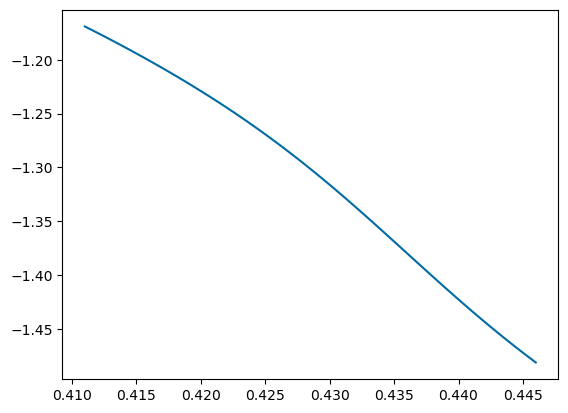

In [110]:
obs = E_samples/N
U_b = compute_obs(obs, beta_list, Zs, params)

plt.plot(beta_list, U_b)

In [ ]:
#Extracting results of simulations

folder_sim = 'data_ISING_2D_complete'
files_sim = os.listdir(folder_sim)
sim = []
beta_complete = []
for file in files_sim:
    #extracting parameters from file name
    pattern_beta = r"beta(.*?)time"
    beta= float(re.findall(pattern_beta, file)[0])
    pattern_N = r"N(.*?)_L"
    N = int(re.findall(pattern_N, file)[0])
    
    data = np.loadtxt(folder_sim + '/' + file)
    energy = data[:,1]
    energy = energy[N_cut::thinning]
    energy = energy/N
    sim.append(np.mean(energy))
    beta_complete.append(beta)

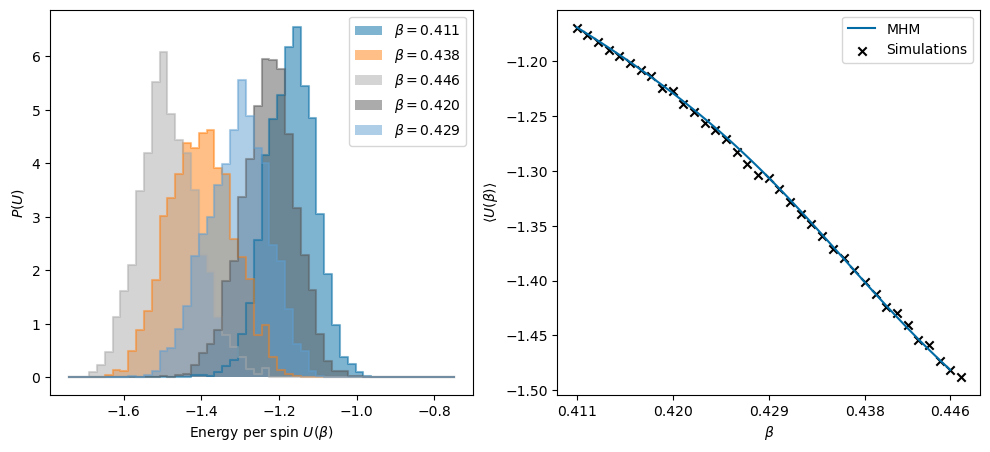

In [112]:
#plotting the results
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

#Histogramming the energy distributions
for E, beta in zip(E_samples, beta_samples):
    counts, _ = np.histogram(E/N, bins=E_bins, density=True)
    ax[0].fill_between(bin_centers, counts, step  = 'mid', alpha=0.5, label=r'$\beta ={:0.3f} $'.format(beta))
    ax[0].step(bin_centers, counts, where  = 'mid', alpha=0.5)
    
ax[0].legend()
ax[0].set_xlabel(r'Energy per spin $U(\beta)$')
ax[0].set_ylabel(r'$P(U)$')


ax[1].plot(beta_list, U_b, label='MHM')

ax[1].scatter(np.array(beta_complete), sim, color='black', label = 'Simulations', marker='x')
ax[1].set_xlabel(r'$\beta$')
ax[1].set_ylabel(r'$ \langle U(\beta) \rangle $')
ax[1].legend()
ax[1].set_xticks(sorted(np.array(beta_samples)))

plt.savefig('plots/MHM.png')

### Specific heat changing L

In [115]:
#listing the files with the simulations
folder = 'data_ISING_2D_changing_L'
files = os.listdir(folder)

#hyperparameter
N_cut = 10_000
thinning = 200

#Bins of energy 
E_bins = np.linspace(-1.75, -0.74, 51)
bin_centers = (E_bins[1:]+E_bins[:-1])/2

#Lists to store data
E_samples = []
beta_samples = []
L_samples = []
N_samples = []

In [116]:
for file in files:
    #extracting parameters from file name
    pattern_beta = r"beta(.*?)time"
    beta= float(re.findall(pattern_beta, file)[0])

    pattern_N = r"N(.*?)_L"
    N = int(re.findall(pattern_N, file)[0])

    pattern_timesteps = r"time(.*?).txt"
    timesteps = int(re.findall(pattern_timesteps, file)[0])

    L = int(np.sqrt(N))

    #extracting data from file
    data = np.loadtxt(folder + '/' + file)
    time = data[:,0]
    energy = data[:,1]

    #thinning and cutting the data
    time = time[N_cut::thinning]
    energy = energy[N_cut::thinning]

    #energy per spin

    E_samples.append(energy)
    beta_samples.append(beta)
    L_samples.append(L)
    N_samples.append(N)

E_samples = np.array(E_samples)
beta_samples = np.array(beta_samples)

params = [beta_samples, E_samples, L_samples, N_samples]